In [1]:
%matplotlib inline

import os
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import pymaster as nmt
from scipy.interpolate import interp1d
from astropy.io import fits

In [2]:
y_mask = hp.read_map('/home/zgd/cmb_y/ver1/Planck/mask/COM_CompMap_Compton-SZMap-masks_2048_R2.01.fits', field=1)
y_mask_LFI = hp.read_map('/home/zgd/cmb_y/ver1/Planck/mask/LFI_inpainting_bool.fits', field=0)
y_mask_HFI = hp.read_map('/home/zgd/cmb_y/ver1/Planck/mask/HFI_inpainting_bool.fits', field=0)
print('read complete, apodizing...')

aposcale = 1.0
# apodize
y_mask_LFI_apodized = nmt.mask_apodization(y_mask_LFI, aposcale, apotype='C1')
y_mask_HFI_apodized = nmt.mask_apodization(y_mask_HFI, aposcale, apotype='C1')

y_mask = y_mask*y_mask_LFI_apodized*y_mask_HFI_apodized

read complete, apodizing...


0.4197986133714097
0.5857119957605997


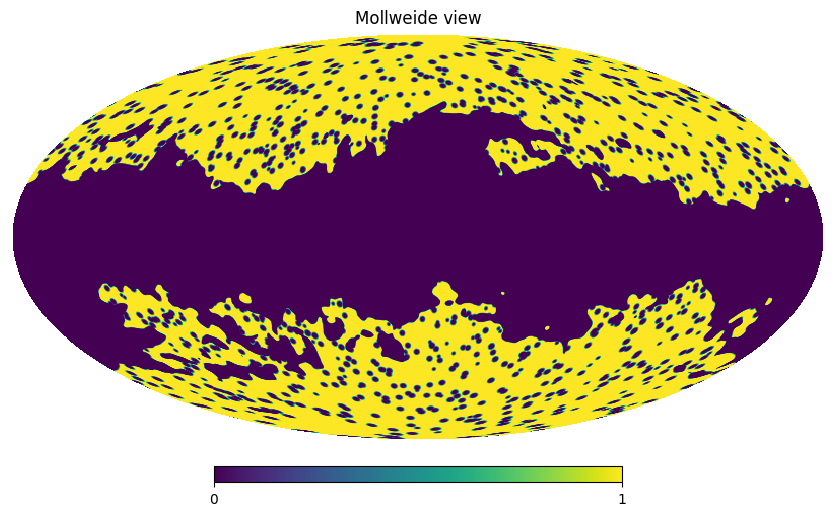

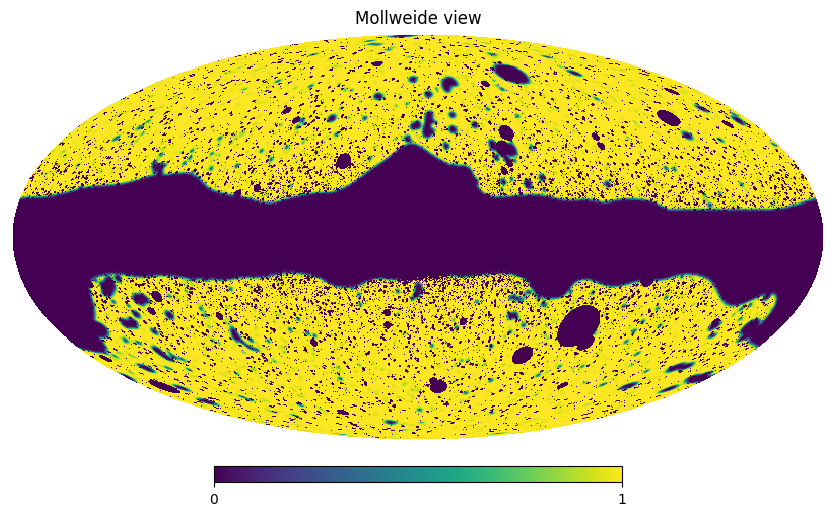

In [3]:
NSIDE =2048

gal_mask = hp.read_map('/home/zgd/cmb_y/ver1/unWISE/mask/mask_unWISE_full_v10.fits', field=0)

weight0 = hp.read_map('/home/zgd/cmb_y/ver1/unWISE/weights/blue_w2_5sig_weights.fits')
weight1 = hp.read_map('/home/zgd/cmb_y/ver1/unWISE/weights/blue_star_weights.fits')
gal_weights = hp.ud_grade(weight0*weight1,NSIDE)

hdul = fits.open('/home/zgd/cmb_y/ver1/unWISE/loss/unmaskedareafrac-flag.fits')
gal_loss = hdul[0].data
hdul.close()

hp.mollview(y_mask)
print(np.sum(y_mask)/(12*2048**2))
hp.mollview(gal_mask)
print(np.sum(gal_mask)/(12*2048**2))

In [9]:
def get_galaxy_map(path:str,weighted=True,masked=True,lossed=True,normed=False):

    print('reading map {}...'.format(path))
    if path.split('.')[-1] == 'fits':
        raw_map = hp.read_map(path, field=0)
    if path.split('.')[-1] == 'npy':
        raw_map = np.load(path)
    
    if weighted:
        print('weighting map...')
        raw_map = raw_map*gal_weights

    if masked:
        print('masking map...')
        raw_map = raw_map*gal_mask

    if lossed:
        print('compensating foreground loss...')
        raw_map = raw_map/gal_loss
        raw_map[gal_loss == 0] = 0
    
    if normed:
        print('normalizing...')
        eff_pix = np.sum(gal_mask)
        map_mean = np.sum(raw_map*gal_mask)/eff_pix
        overdensity = raw_map/map_mean - 1
        print('calculated fsky = {}'.format(eff_pix/np.shape(y_mask)[0]))
    else:
        print('skipped normalization...')
        overdensity = raw_map
    
    print('done.')
    return overdensity

In [8]:
np.seterr(divide='ignore', invalid='ignore')
galaxy_density = get_galaxy_map('/home/zgd/cmb_y/ver1/unWISE/blue/numcounts_map1_2048-r1-v2_flag.fits',masked=False,weighted=True,normed=True)
galaxy_w1 = get_galaxy_map('/home/zgd/cmb_y/ver1/unWISE/blue_w1_mean/map_w1_mean.npy',masked=False,weighted=True)
galaxy_w2 = get_galaxy_map('/home/zgd/cmb_y/ver1/unWISE/blue_w2_mean/map_w2_mean.npy',masked=False,weighted=True)
# galaxy_density_unweighted = get_galaxy_map('blue',weighted=False)
# galaxy_density_unlossed = get_galaxy_map('blue',weighted = True,lossed = 2.0)

reading map /home/zgd/cmb_y/ver1/unWISE/blue/numcounts_map1_2048-r1-v2_flag.fits...
weighting map...
compensating foreground loss...
skipped normalization...
done.
reading map /home/zgd/cmb_y/ver1/unWISE/blue_w1_mean/map_w1_mean.npy...
weighting map...
compensating foreground loss...
skipped normalization...
done.
reading map /home/zgd/cmb_y/ver1/unWISE/blue_w2_mean/map_w2_mean.npy...
weighting map...
compensating foreground loss...
skipped normalization...
done.


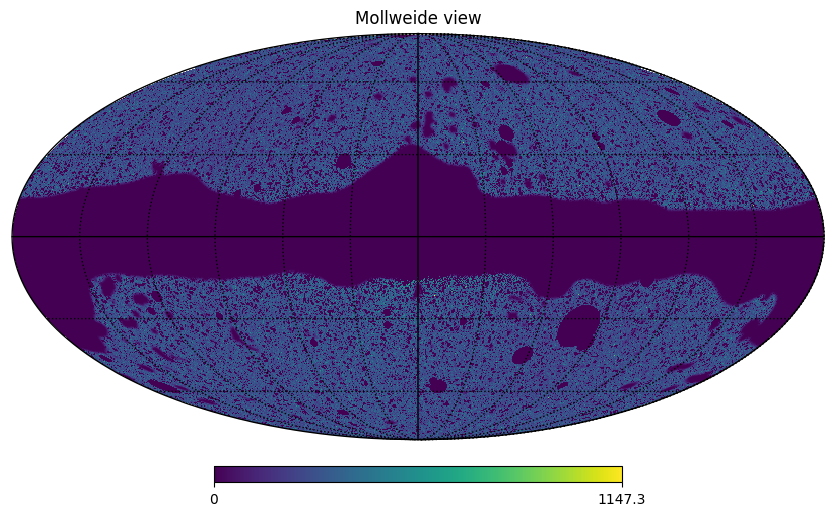

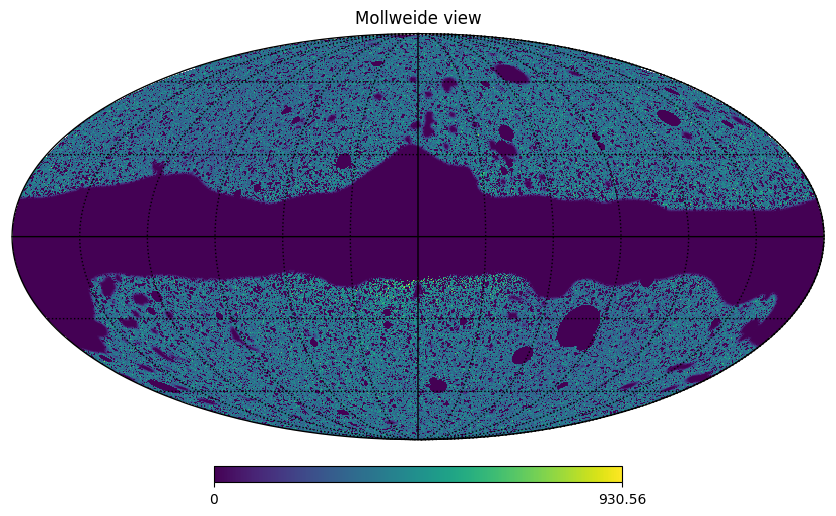

In [6]:
hp.mollview(galaxy_w1)
hp.graticule()
hp.mollview(galaxy_w2)
hp.graticule()

In [7]:
CUT = 0 #deg

mask_cut = np.ones(12*2048**2)
pix_index = np.arange(12*2048**2)
theta,phi = hp.pix2ang(2048,pix_index)
mask_cut[pix_index[(theta<(90+CUT)/180*np.pi) &(theta>(90-CUT)/180*np.pi)]] = 0

LMAX = 2048
LMIN = 128

f_sky_cut = np.sum(gal_mask*y_mask*mask_cut)/np.shape(gal_mask)[0]
print('fsky_cut = {}'.format(f_sky_cut))

alm_w1 = hp.map2alm(galaxy_w1*mask_CMB*mask_cut*mask_galaxy,lmax=LMAX,gal_cut=CUT)
alm_w1/=np.sqrt(f_sky_cut)

alm_w2 = hp.map2alm(galaxy_w2*mask_CMB*mask_cut*mask_galaxy,lmax=LMAX,gal_cut=CUT)
alm_w2/=np.sqrt(f_sky_cut)


NameError: name 'dir_unWISE' is not defined

In [8]:
ymap_path_dict= {'no_deprojection':'/home/zgd/cmb_y/ver1/Planck/ymap/no_deprojection_standard_full.fits',
                 'CIB+CMB_default':'/home/zgd/cmb_y/ver1/Planck/ymap/deproject_CMB_CIB_default_standard_full.fits',
                 'CIB+CMB+dT+dbeta_default':'/home/zgd/cmb_y/ver1/Planck/ymap/deproject_CMB5_CIB_CIBdbeta_CIBdT_default_standard_full.fits',
                 'CIB+CMB_T=24_beta=1.0':'/home/zgd/cmb_y/ver1/Planck/ymap/SED/deproject_CMB_CIB_beta1.0_T24_standard_full.fits',
                 'CIB+CMB_T=24_beta=1.2':'/home/zgd/cmb_y/ver1/Planck/ymap/SED/deproject_CMB_CIB_beta1.2_T24_standard_full.fits',
                 'CIB+CMB_T=24_beta=1.4':'/home/zgd/cmb_y/ver1/Planck/ymap/SED/deproject_CMB_CIB_beta1.4_T24_standard_full.fits',
                 'CIB+CMB_T=24_beta=1.6':'/home/zgd/cmb_y/ver1/Planck/ymap/SED/deproject_CMB_CIB_beta1.6_T24_standard_full.fits',
                 'CIB+CMB_T=10.14_beta=1.4':'/home/zgd/cmb_y/ver1/Planck/ymap/SED/deproject_CMB_CIB_beta1.4_T10.14_standard_full.fits',
                 'CIB+CMB_T=10.14_beta=1.6':'/home/zgd/cmb_y/ver1/Planck/ymap/SED/deproject_CMB_CIB_beta1.6_T10.14_standard_full.fits',
                 'CIB+CMB_T=10.14_beta=1.9':'/home/zgd/cmb_y/ver1/Planck/ymap/SED/deproject_CMB_CIB_beta1.9_T10.14_standard_full.fits',}

In [9]:
ysample = 'CIB+CMB_T=10.14_beta=1.9'
ymap = hp.read_map(ymap_path_dict[ysample])
ymap = hp.ud_grade(ymap,2048)
ymap = ymap*mask_CMB*mask_cut*mask_galaxy
gal_counts = get_galaxy_map('blue_count',weighted=True,masked=True,lossed=True,normed=False)
ymap /= gal_counts
ymap[gal_counts==0] = 0

alm_y = hp.map2alm(ymap,lmax=LMAX,gal_cut=CUT)
alm_y /= np.sqrt(f_sky_cut)
#Filter out low multipoles
filtered_alm_w1 = hp.almxfl(alm_w1, hp.Alm.getlm(LMAX)[0] >= LMIN)
filtered_alm_w2 = hp.almxfl(alm_w2, hp.Alm.getlm(LMAX)[0] >= LMIN)
filtered_alm_y = hp.almxfl(alm_y, hp.Alm.getlm(LMAX)[0] >= LMIN)
#Reconstruct the map, with lower resolution
nside = 128
w1 = hp.alm2map(filtered_alm_w1,nside)
w2 = hp.alm2map(filtered_alm_w2,nside)
c12 = w1-w2
y = hp.alm2map(filtered_alm_y,nside)

reading map blue_count...
weighting map...
masking map...
compensating foreground loss...


/tmp/ipykernel_4454/3896908547.py:33: RuntimeWarning: invalid value encountered in divide
  raw_map = raw_map/loss
/tmp/ipykernel_4454/64790560.py:6: RuntimeWarning: divide by zero encountered in divide
  ymap /= gal_counts
/tmp/ipykernel_4454/64790560.py:6: RuntimeWarning: invalid value encountered in divide
  ymap /= gal_counts


skipped normalization...
done.




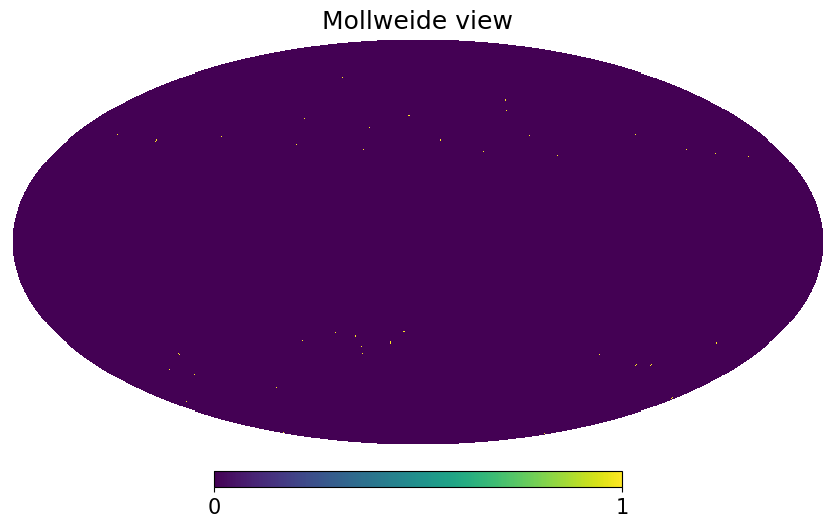

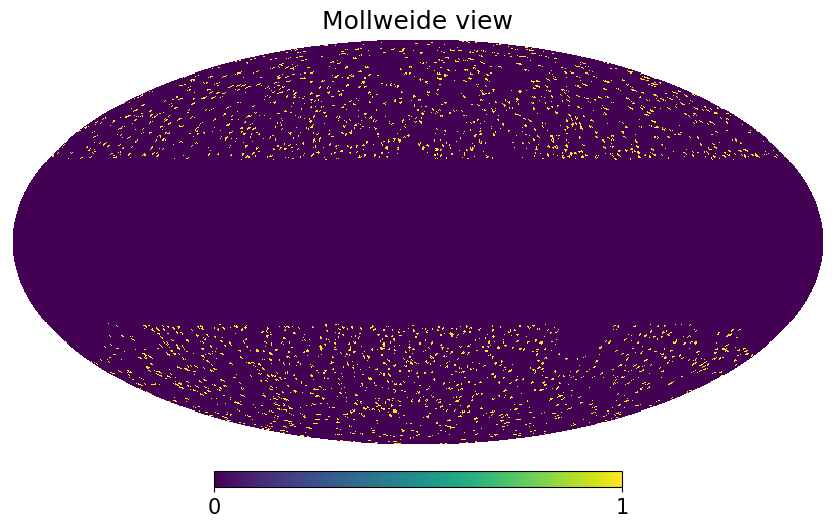

In [28]:
tail_data = (w1<-200)&(c12>50)
mask_low = hp.ud_grade(mask_galaxy*mask_CMB,128)
mask_low_bool = mask_low >0.9
masked_tail = tail_data*mask_low_bool
hp.mollview(masked_tail)
hp.mollview(tail_data)

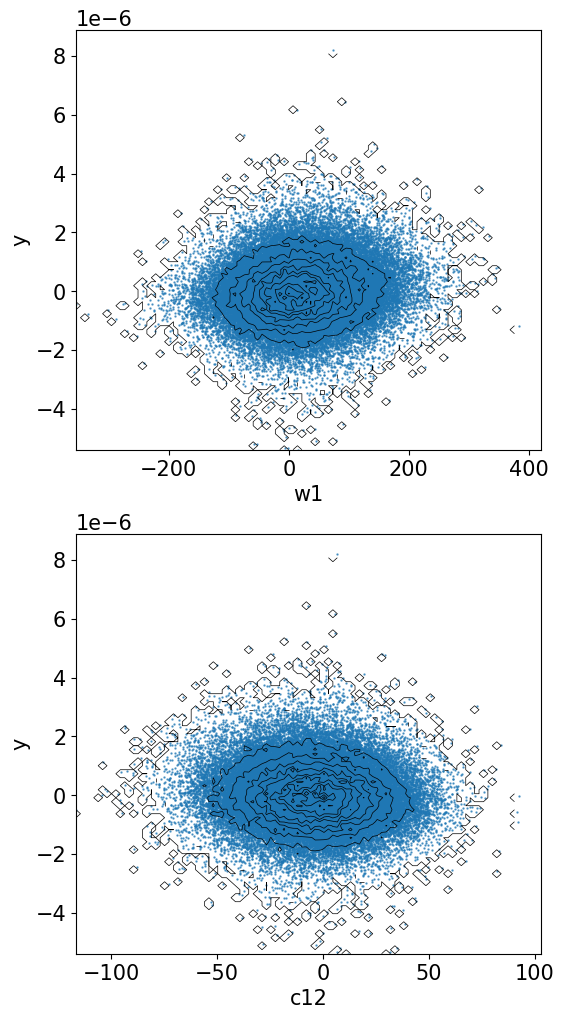

In [32]:
fig, ax = plt.subplots(2, figsize=(6,12))

mask_low = hp.ud_grade(mask_CMB*mask_cut*mask_galaxy,nside)
mask_bool = mask_low >0.9

w1_masked = (w1*mask_low)[mask_bool]
c12_masked = (c12*mask_low)[mask_bool]
y_masked = (y*mask_low)[mask_bool]

ax[0].scatter(w1_masked,y_masked,s=0.5,alpha=0.7)
ax[1].scatter(c12_masked,y_masked,s=0.5,alpha=0.7)
H1, xedges1, yedges1 = np.histogram2d(w1_masked,y_masked,bins=100)
H2, xedges2, yedges2 = np.histogram2d(c12_masked,y_masked,bins=100)
ax[0].contour(xedges1[:-1], yedges1[:-1], H1.T, levels=10, linewidths=0.5, colors='k')
ax[1].contour(xedges2[:-1], yedges2[:-1], H2.T, levels=10, linewidths=0.5, colors='k')
ax[0].set_xlabel('w1')
ax[0].set_ylabel('y')
ax[1].set_xlabel('c12')
ax[1].set_ylabel('y')

fig.savefig('./output/w1w2fit/{}_scatter.png'.format(ysample),dpi=400)
X = np.column_stack((w1_masked,c12_masked))

# Fit the linear model to the filtered coefficients
x, residuals, rank, s = np.linalg.lstsq(X, y_masked, rcond=None)

# Extract the slope and intercept
x1 = x[0]
x2 = x[1]
# Compute the uncertainty of each fitting parameter
covariance_matrix = s[0] * np.linalg.inv(np.dot(X.T, X))
uncertainty_x1 = np.sqrt(covariance_matrix[0][0])
uncertainty_x2 = np.sqrt(covariance_matrix[1][1])



In [221]:
print(x1,uncertainty_x1)
print(x2,uncertainty_x2)

1.3700363898349845e-09 0.008809903013955261
-9.075426249353786e-10 0.033644444518381854


Text(0.5, 1.0, 'c12')

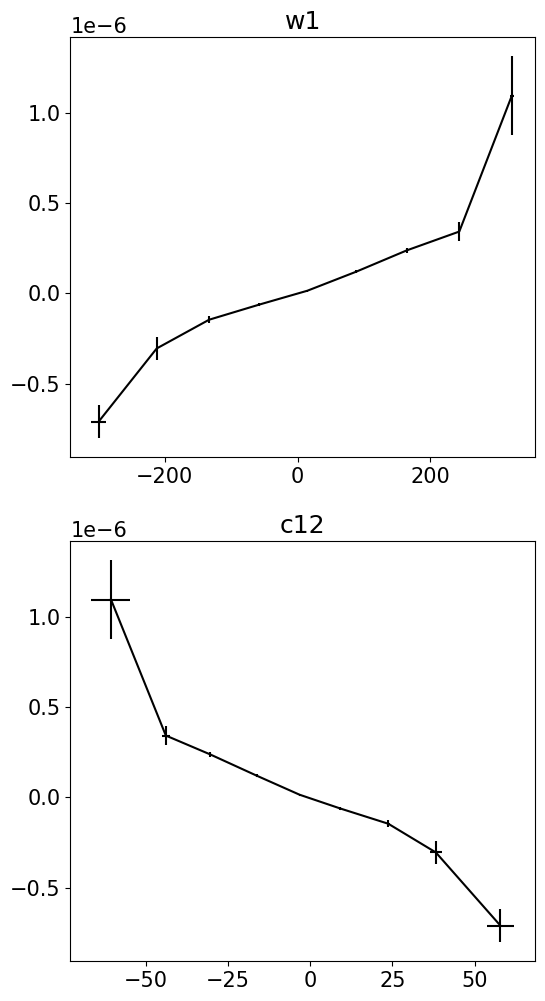

In [33]:
bins = np.linspace(np.min(w1_masked),np.max(w1_masked),10,endpoint=True)
fig, ax = plt.subplots(2, figsize=(6,12))
y_binned = np.zeros(len(bins)-1)
w1_binned = np.zeros(len(bins)-1)
c12_binned = np.zeros(len(bins)-1)
y_binned_err = np.zeros(len(bins)-1)
w1_binned_err = np.zeros(len(bins)-1)
c12_binned_err = np.zeros(len(bins)-1)

for i in range(len(bins)-1):
    mask_bin = (w1_masked>bins[i])&(w1_masked<bins[i+1])
    num_bin = np.sum(mask_bin)

    y_binned[i] = np.mean(y_masked[mask_bin])
    y_binned_err[i] = np.std(y_masked[mask_bin])/np.sqrt(num_bin)

    w1_binned[i] = np.mean(w1_masked[mask_bin])
    w1_binned_err[i] = np.std(w1_masked[mask_bin])/np.sqrt(num_bin)

    c12_binned[i] = np.mean(c12_masked[mask_bin])
    c12_binned_err[i] = np.std(c12_masked[mask_bin])/np.sqrt(num_bin)


    # print(len(w1[(w1>bins[i])&(w1<bins[i+1])]))
    # print('standard deviation of w1 = {}'.format(w1_binned_err))
    # print('standard deviation of c12 = {}'.format(c12_binned_err))
    # print('standard deviation of y = {}'.format(y_binned_err))

ax[0].errorbar(w1_binned,y_binned,xerr = w1_binned_err,yerr=y_binned_err,c='k')
ax[1].errorbar(c12_binned,y_binned,xerr = c12_binned_err,yerr=y_binned_err,c='k')

#np.save('./output/w1w2fit/CIBdTdbeta.npy',np.array([w1_binned,c12_binned,y_binned,w1_binned_err,c12_binned_err,y_binned_err]))

ax[0].set_title('w1')
ax[1].set_title('c12')
#fig.savefig('w1_w2_CIBdTdbeta.png',dpi=400)
# ax[0,0].set_yscale('log')
# ax[0,1].set_yscale('log')
# ax[1,0].set_yscale('log')
# ax[1,1].set_yscale('log')


In [34]:
def fit_func(x,y,a,b,c):
    return a*x+b*y+c

def loss(x):
    return np.sum((fit_func(w1_masked,c12_masked,x[0],x[1],x[2])-y_masked)**2)

[ 1.16128553e-09 -7.89368880e-10  3.97893433e-09  1.49999640e+01
  1.49999642e+01  1.49999642e+01]


/tmp/ipykernel_4454/3504489299.py:21: RuntimeWarning: invalid value encountered in divide
  H1/=H


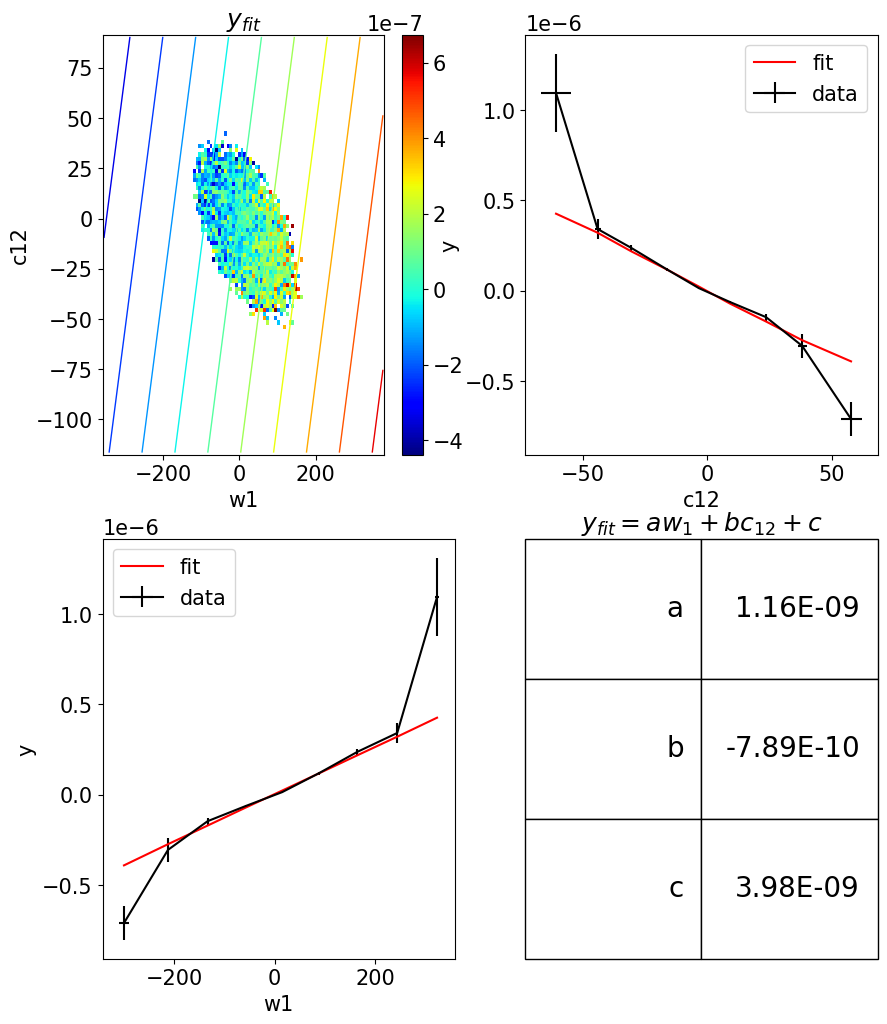

In [35]:
from scipy.optimize import minimize

res = minimize(loss, [1E-7,-1E-7,-1E-7,-1E-7,1E-7,1E-7], method='Powell', tol=1E-20)

print(res.x)
fig,ax = plt.subplots(2,2,figsize=(10,12))
y_fit = fit_func(w1_binned,c12_binned,res.x[0],res.x[1],res.x[2])
y_res = y_fit-y_binned

y_masked_fit = fit_func(w1_masked,c12_masked,res.x[0],res.x[1],res.x[2])
#map y_res to colormap

def gen_color(x):
    x-=np.min(x)
    x/=np.max(x)
    x*=255
    return x.astype(int)

H,xedges,yedges = np.histogram2d(w1_masked,c12_masked,100)
H1,xedges1,yedges1 = np.histogram2d(w1_masked,c12_masked,100,weights=y_masked)
H1/=H
H1[H<20] = np.nan

w1_grid,c12_grid = np.meshgrid(xedges[:-1],yedges[:-1])

y_fit_mesh = fit_func(w1_grid,c12_grid,res.x[0],res.x[1],res.x[2])
ax[0,0].contour(w1_grid,c12_grid,y_fit_mesh,levels=10,linewidths=1.0,cmap='jet')
#plt.scatter(w1_masked,c12_masked,c=y_res,s=0.5,alpha=0.25)
ax[0,0].set_xlabel('w1')
ax[0,0].set_ylabel('c12')
ax[0,0].set_title('$y_{fit}$')
im = ax[0,0].pcolormesh(w1_grid,c12_grid,H1.T,cmap='jet')
cbar = fig.colorbar(im,ax=ax[0,0])
# ax[0,0].contour(xedges1[:-1], yedges1[:-1], H1.T, levels=10, linewidths=0.5, colors='k')
ax[1,0].errorbar(w1_binned,y_binned,xerr = w1_binned_err,yerr=y_binned_err,c='k',label ='data')
ax[1,0].plot(w1_binned,y_fit,c='r',label='fit')
ax[1,0].set_xlabel('w1')
ax[1,0].set_ylabel('y')
ax[1,0].legend()
ax[0,1].errorbar(c12_binned,y_binned,xerr = c12_binned_err,yerr=y_binned_err,c='k',label ='data')
ax[0,1].plot(c12_binned,y_fit,c='r',label='fit')
ax[0,1].set_xlabel('c12')
ax[0,1].set_ylabel('y')
ax[0,1].legend()
ax[1,1].axis('off')
ax[1,1].axis('tight')

param_table = ax[1,1].table(cellText=[['a',format(res.x[0],'.2E')],['b',format(res.x[1],'.2E')],['c',format(res.x[2],'.2E')]],loc='center',bbox=[0,0,1,1])
param_table.set_fontsize(20)
ax[1,1].set_title('$y_{fit} = a w_1+b c_{12}+c$')

fig.savefig('./output/w1w2fit/w1_w2_{}_fit.png'.format(ysample),dpi=400)

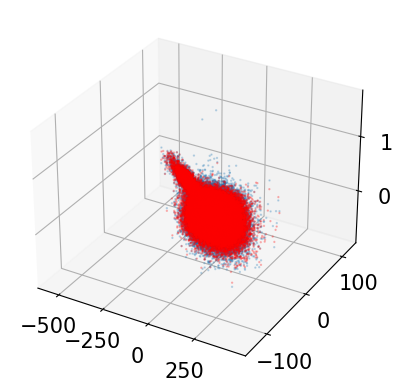

In [225]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(w1_masked,c12_masked,y_masked,s=0.5,alpha=0.25)
ax.scatter(w1_masked,c12_masked,y_masked_fit,s=0.5,alpha=0.25,c='r')